In [1]:
import pyslim, tskit, msprime
from IPython.display import SVG
import numpy as np
import util

np.random.seed(1234)

(sec_vignette_space)=


# Vignette: A spatial simulation

Here we'll talk through a typical workflow with pyslim,
which will:

1. Simulate data with SLiM, remembering some ancestral individuals.
2. Recapitate and mutate.
3. Take a subsample of the modern and ancestral individuals.
4. Get these individual locations and make a map.
5. Compute divergences between individuals, and plot against geographic distance.
6. Write out a VCF file of these individuals' genotypes and other data for use by other programs.


## Simulation

Here is a simple spatial SLiM recipe that simulates 1000 individuals on a spatial landscape.
The focus of this vignette is not on SLiM, so we won't go into detail here.
Here are notes:

1. It does not have *any* mutations: we'll add these on afterwards.
2. There is local fecundity regulation of population density: individuals with more neighbors
   have fewer offspring.
3. We run the simulation for 2000 time steps, and "remember" everyone who is alive at time step 1000.

```{literalinclude} vignette_space.slim
```

In [2]:
%%bash
slim -s 23 vignette_space.slim

// Initial random seed:


23


// RunInitializeCallbacks():


initializeSLiMModelType(modelType = 'nonWF');


initializeSLiMOptions(dimensionality = 'xy');


initializeTreeSeq();


initializeMutationRate(0);


initializeMutationType(1, 0.5, "f", 0);


initializeGenomicElementType(1, m1, 1);


initializeGenomicElement(g1, 0, 99999999);


initializeRecombinationRate(1e-08);


initializeInteractionType(1, "xy", reciprocal=T, maxDistance=3);


// Starting run at tick <start>:


1 


Done.


Ok, now let's have a quick look at the output:

In [3]:
slim_ts = tskit.load("spatial_sim.trees")
print(f"The tree sequence has {slim_ts.num_trees} trees\n"
      f"on a genome of length {slim_ts.sequence_length},\n"
      f"{slim_ts.num_individuals} individuals, {slim_ts.num_samples} 'sample' genomes,\n"
      f"and {slim_ts.num_mutations} mutations.")

The tree sequence has 36209 trees
on a genome of length 100000000.0,
2497 individuals, 4994 'sample' genomes,
and 0 mutations.


It makes sense we have no mutations: we haven't added any yet.
The tree sequence is recording the relationship between 5,424 genomes (the "samples"),
which requires 37,095 distinct trees along the genome.
Individuals are diploid, which explains why the number of individuals
is equal to half the number of samples.
Let's have a look at how old those individuals are,
by tabulating when they were born:

In [4]:
individual_times = slim_ts.individuals_time
for t in np.unique(individual_times):
    print(f"There are {np.sum(individual_times == t)} individuals from time {t}.")

There are 618 individuals from time 0.0.
There are 298 individuals from time 1.0.
There are 161 individuals from time 2.0.
There are 85 individuals from time 3.0.
There are 29 individuals from time 4.0.
There are 28 individuals from time 5.0.
There are 9 individuals from time 6.0.
There are 6 individuals from time 7.0.
There are 3 individuals from time 8.0.
There are 4 individuals from time 9.0.
There are 1 individuals from time 11.0.
There are 647 individuals from time 1000.0.
There are 307 individuals from time 1001.0.
There are 142 individuals from time 1002.0.
There are 82 individuals from time 1003.0.
There are 36 individuals from time 1004.0.
There are 17 individuals from time 1005.0.
There are 10 individuals from time 1006.0.
There are 9 individuals from time 1007.0.
There are 1 individuals from time 1008.0.
There are 1 individuals from time 1009.0.
There are 2 individuals from time 1010.0.
There are 1 individuals from time 1011.0.


These "times" record the birth times of each individual.
These are *tskit* times, which are in units of "time ago",
so for instance, there are 343 individuals born one time unit before the end of the simulation
and 167 born two time units before the end of the simulation.
(This confusing choice of units is because tskit was developed for msprime, a coalescent simulator.)
This also tells us that there's a bunch of individuals born around 1000 time steps ago,
when we asked SLiM to Remember everyone alive at the time,
and some more in the past few time steps, i.e., the present.
This is a non-Wright-Fisher simulation,
and so individuals may live for more than one time step (even up to age 10, it seems).
Let's check that all these individuals are alive at either (a) today or (b) 1000 time steps ago.

In [5]:
for t in [0, 1000]:
  alive = pyslim.individuals_alive_at(slim_ts, t)
  print(f"There were {len(alive)} individuals alive {t} time steps in the past.")

There were 1242 individuals alive 0 time steps in the past.
There were 1255 individuals alive 1000 time steps in the past.


And, 1378 + 1334 is 2712, the total number of individuals.
So, this all checks out.


## Recapitation and mutation

Next, we want to (a) simulate some ancestral diversity and (b) add in neutral mutations.
Please see [Haller et al (2019)](https://onlinelibrary.wiley.com/doi/abs/10.1111/1755-0998.12968>)
for the why and how of these steps.
But, first let's see if recapitation is necessary:
on how much of the genome is the tree sequence not coalesced?
In other words, recapitation adds diversity present in the initial generation;
will it make a difference? 
In fact, *no* segments of the genome have coalesced:

In [6]:
print(f"Number of trees with only one root: {sum([t.num_roots == 1 for t in slim_ts.trees()])}\n"
      f"Number with more than one root: {sum([t.num_roots > 0 for t in slim_ts.trees()])}")

Number of trees with only one root: 0
Number with more than one root: 36209


Next, we will:

1. Recapitate, running a coalescent simulation to build ancestral trees.
2. Mutate, adding neutral variation.
3. Save the resulting tree sequence to disk for future use.

We *won't* simplify, since we may as well keep around all the information.
But, if we did (e.g., if we were running a large number of simulations),
we would need to pass ``keep_input_roots=True`` to allow recapitation. 

:::{note}
   The units of time in the tree sequence are SLiM's "time steps", and
   so are not necessarily equal to the mean generation time in a
   non-Wright-Fisher model. Per-generation rates need to be divided by the
   mean generation time, which can be measured in SLiM.
:::

In [7]:
recap_ts = pyslim.recapitate(slim_ts, recombination_rate=1e-8, ancestral_Ne=1000)
ts = msprime.sim_mutations(
         recap_ts,
         rate=1e-8,
         model=msprime.SLiMMutationModel(type=0),
         keep=True,
)
ts.dump("spatial_sim.recap.trees")

print(f"The tree sequence now has {ts.num_trees} trees,\n"
       " and {ts.num_mutations} mutations.")

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


The tree sequence now has 39786 trees,
 and {ts.num_mutations} mutations.


See [](sec_tutorial_adding_neutral_mutations) for discussion of the options to
{func}`msprime.sim_mutations`.


We will have no further use for ``slim_ts`` or for ``recap_ts``;
we've just given them separate names for tidyness.
And, since the original SLiM mutation had no mutations, we didn't need to specify ``keep=True``
in {func}`sim_mutations <msprime.sim_mutations>`, but if we *had* put down selected mutations with SLiM
we'd probably want to keep them around.


## Take a sample of individuals

Now it's time to compute some things.
In real life we don't get to work with *everyone* usually,
so we'll take a subset of individuals.
The range we have simulated has width and height 35 units,
with a population density of around 1 per unit area.
We'll get genomes to work with by pulling out

1. All the modern individuals in the five squares of width 5 in the corners of the range
   and the center, and
2. Five individuals sampled randomly from everyone alive 1000 time steps ago.

In [8]:
np.random.seed(23)

alive = pyslim.individuals_alive_at(ts, 0)
locs = ts.individuals_location[alive, :]

W = 35
w = 5
groups = {
  'topleft' : alive[np.logical_and(locs[:, 0] < w, locs[:, 1] < w)],
  'topright' : alive[np.logical_and(locs[:, 0] < w, locs[:, 1] > W - w)],
  'bottomleft' : alive[np.logical_and(locs[:, 0] > W - w, locs[:, 1] < w)],
  'bottomright' : alive[np.logical_and(locs[:, 0] > W - w, locs[:, 1] > W - w)],
  'center' : alive[np.logical_and(np.abs(locs[:, 0] - W/2) < w/2,
                                  np.abs(locs[:, 1] - W/2) < w/2)]
  }

old_ones = pyslim.individuals_alive_at(ts, 1000)
groups['ancient'] = np.random.choice(old_ones, size=5)

for k in groups:
  print(f"We have {len(groups[k])} individuals in the {k} group.")

We have 17 individuals in the topleft group.
We have 42 individuals in the topright group.
We have 32 individuals in the bottomleft group.
We have 23 individuals in the bottomright group.
We have 26 individuals in the center group.
We have 5 individuals in the ancient group.


To keep names associated with each subset of individuals,
we've kept the individuals in a dict, so that for instance
``groups["topleft"]`` is an array of all the individual IDs that are in the top left corner.
The IDs of the ancient individuals we will work with are kept in the array ``ancient``.

Let's do a quick consistency check, that everyone in ``ancient`` was actually born around 1000 time steps ago:

In [9]:
for i in groups["ancient"]:
  ind = ts.individual(i)
  # TODO: will work on next tskit release
  # assert(ind.time >= 1000 and ind.time < 1020)
  time = ts.node(ind.nodes[0]).time
  assert(time >= 1000 and time < 1020)

No errors occurred, so that checks out.

## Plotting locations

We should check this: plot where these individuals lie
relative to everyone else.
The individuals locations are available as a property of individuals,
but to make things easier, it's also present in a `num_individuals x 3`
numpy array as ``ts.individuals_location``.
(There are three columns because SLiM allows for
`(x, y, z)` coordinates, but we'll just use the first two.)
Since ``groups["topleft"]`` is an array of individual IDs,
we can pull out the locations of the "topleft" individuals
by indexing the rows of the individual location array:

In [10]:
print("Locations:")
all_locs = ts.individuals_location
print(all_locs)
print("shape:")
all_locs.shape
print("topleft locations shape:")
all_locs[groups["topleft"], :].shape

Locations:
[[24.37301558 24.41729922  0.        ]
 [22.05227884  1.55546446  0.        ]
 [ 7.66744824 28.54097583  0.        ]
 ...
 [33.8697077   7.94441404  0.        ]
 [16.2380576   3.78547076  0.        ]
 [ 3.13074587  0.38643692  0.        ]]
shape:
topleft locations shape:


(17, 3)

Using this, we can easily plot the locations of all the individuals from today
(on the left) and 1000 time steps ago (on the right).
We have to do a bit of mucking around to set the colors so that they reflect
which group each individual is in.

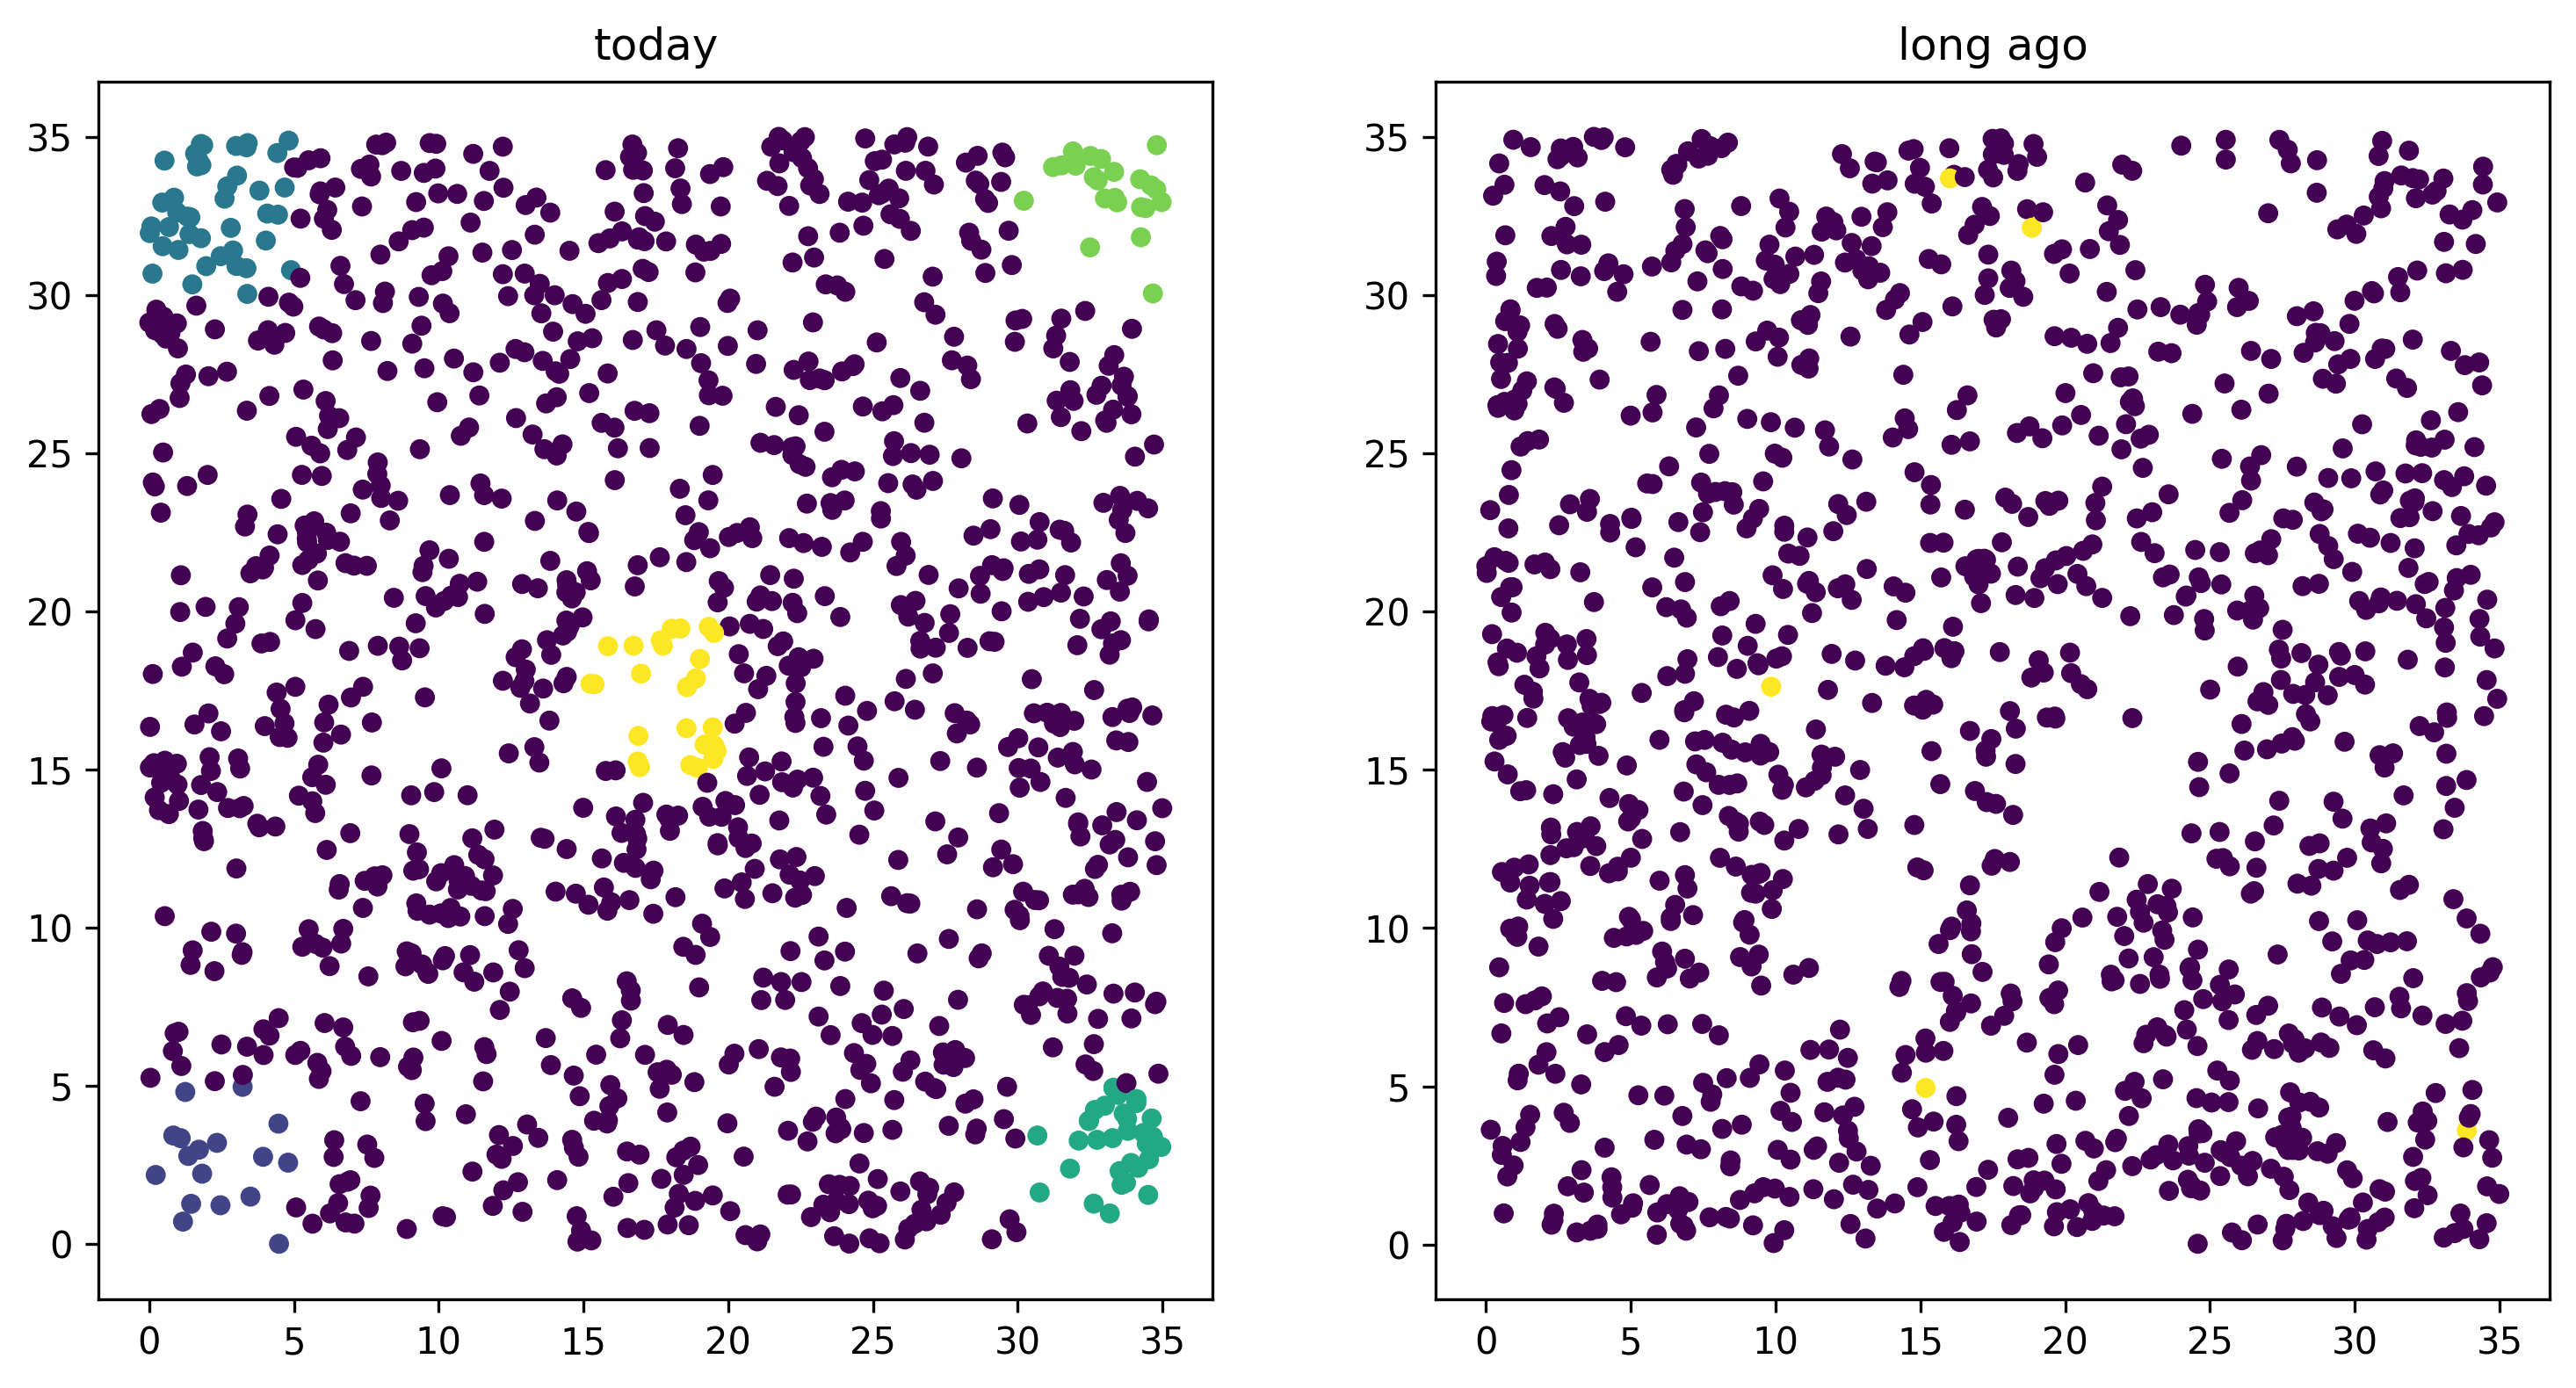

In [11]:
import matplotlib
import matplotlib.pyplot as plt

group_order = ['topleft', 'topright', 'bottomleft', 'bottomright', 'center', 'ancient']
ind_colors = np.repeat(0, ts.num_individuals)
for j, k in enumerate(group_order):
  ind_colors[groups[k]] = 1 + j

old_locs = ts.individuals_location[old_ones, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
ax1.set_title("today")
ax1.scatter(locs[:,0], locs[:,1], s=20, c=ind_colors[alive])
ax2.set_title("long ago")
ax2.scatter(old_locs[:, 0], old_locs[:, 1], s=20, c=ind_colors[old_ones]);

## Isolation by distance

Now, let's look at *isolation by distance*, i.e.,
let's compare geographic and genetic distances.
Here, "genetic distance" will be mean pairwise sequence divergence.
First, we'll compute mean genetic distance between each of our five groups.

The first thing we need to do is some bookkeeping.
So far, we've just worked with *individuals*,
but tree sequence tools, in particular the statistics computation methods from tskit,
are designed to work with *genomes*, also known as "nodes".
So, first we need to pull out the *node IDs* corresponding to the individuals we want.
The things that make up a tree sequence - individuals, nodes, mutations, etcetera -
can generally be examined individually. 
For instance, here's what we have for the the first "ancient" individual:

In [12]:
print(ts.individual(groups['ancient'][0]))

Individual(id=1837, flags=131072, location=array([16.02192465, 33.68672597,  0.        ]), parents=array([-1, -1], dtype=int32), nodes=array([1190, 1191], dtype=int32), metadata={'pedigree_id': 1306914, 'pedigree_p1': 1305559, 'pedigree_p2': 1304766, 'age': 1, 'subpopulation': 1, 'sex': -1, 'flags': 0})


In [13]:
util.pp(ts.individual(groups['ancient'][0]))

Individual(id=1837, flags=131072, location=array([16.02192465, 33.68672597,  0.        ]), parents=array([-1, -1], dtype=int32), nodes=array([1190, 1191], dtype=int32), metadata={
    'pedigree_id': 1306914,
    'pedigree_p1': 1305559,
    'pedigree_p2': 1304766,
    'age': 1,
    'subpopulation': 1,
    'sex': -1,
    'flags': 0
   })


Notice that among other things, each individual carries around a list of their node IDs,
i.e., their genomes.
We need to put these all in a list of lists,
so that, for instance, the first element of the list will have the node IDs of all the genomes
of the individuals in the "topleft" group.
And, since we kept the individual IDs in a dict, which are unordered,
we'll have to do some extra work to make sure we keep track of order.

In [14]:
sampled_nodes = [[] for _ in groups]
for j, k in enumerate(group_order):
  for ind in groups[k]:
     sampled_nodes[j].extend(ts.individual(ind).nodes)

Let's do a consistency check: the number of nodes in each element of this list
should be twice the number of individuals in the corresponding list.

In [15]:
print([len(groups[k]) for k in groups])
print([len(u) for u in sampled_nodes])

[17, 42, 32, 23, 26, 5]
[34, 84, 64, 46, 52, 10]


For instance, in the 'topleft' corner there are 12 diploids,
with 24 nodes. That checks out.

Now, we can compute the matrix of pairwise mean sequence divergences
between and within these sets.
This is done using the {meth}`ts.divergence <tskit.TreeSequence.divergence>` method.

In [16]:
pairs = [(i, j) for i in range(6) for j in range(6)]
group_div = ts.divergence(sampled_nodes, indexes=pairs).reshape((6, 6))

print("\t" + "\t".join(group_order))
for i, group in enumerate(group_order):
  print(f"{group_order[i]}:\t" + "\t".join(map(str, np.round(group_div[i], 7))))

	topleft	topright	bottomleft	bottomright	center	ancient
topleft:	2.98e-05	4.55e-05	4.53e-05	4.72e-05	4.45e-05	4.43e-05
topright:	4.55e-05	2.47e-05	4.98e-05	4.79e-05	4.65e-05	4.55e-05
bottomleft:	4.53e-05	4.98e-05	3.03e-05	4.59e-05	4.5e-05	4.44e-05
bottomright:	4.72e-05	4.79e-05	4.59e-05	2.33e-05	4.45e-05	4.49e-05
center:	4.45e-05	4.65e-05	4.5e-05	4.45e-05	3.98e-05	4.46e-05
ancient:	4.43e-05	4.55e-05	4.44e-05	4.49e-05	4.46e-05	3.52e-05


That's nice, but to look at isolation by distance,
we should actually separate out the individuals.
To do that, we need to create a list of lists of nodes
whose j-th entry is the nodes belonging to the j-th individual,
and to keep track of which group each one belongs to.

In [17]:
ind_nodes = []
ind_group = []
ind_ids = []
for j, group in enumerate(group_order):
  for ind in groups[group]:
     ind_ids.append(ind)
     ind_nodes.append(ts.individual(ind).nodes)
     ind_group.append(group_order[j])

nind = len(ind_ids)
pairs = [(i, j) for i in range(nind) for j in range(i, nind)]
ind_div = ts.divergence(ind_nodes, indexes=pairs)

Here we've only computed divergences in the *upper triangle* of the pairwise divergence matrix,
with heterozygosities on the diagonal.
We'll also need pairwise geographic distances:

In [18]:
geog_dist = np.repeat(0.0, len(pairs))
locs = ts.individuals_location
for k, (i, j) in enumerate(pairs):
  geog_dist[k] = np.sqrt(np.sum(
                    (locs[ind_ids[i], :]
                     - locs[ind_ids[j], :])**2
                 ))

Let's check that makes sense: distances of individuals from themselves should be zero.

In [19]:
for (i, j), x in zip(pairs, geog_dist):
 if i == j:
   assert(x == 0)

Python does not complain, which is good.
Now let's plot genetic distance against geographic distance.

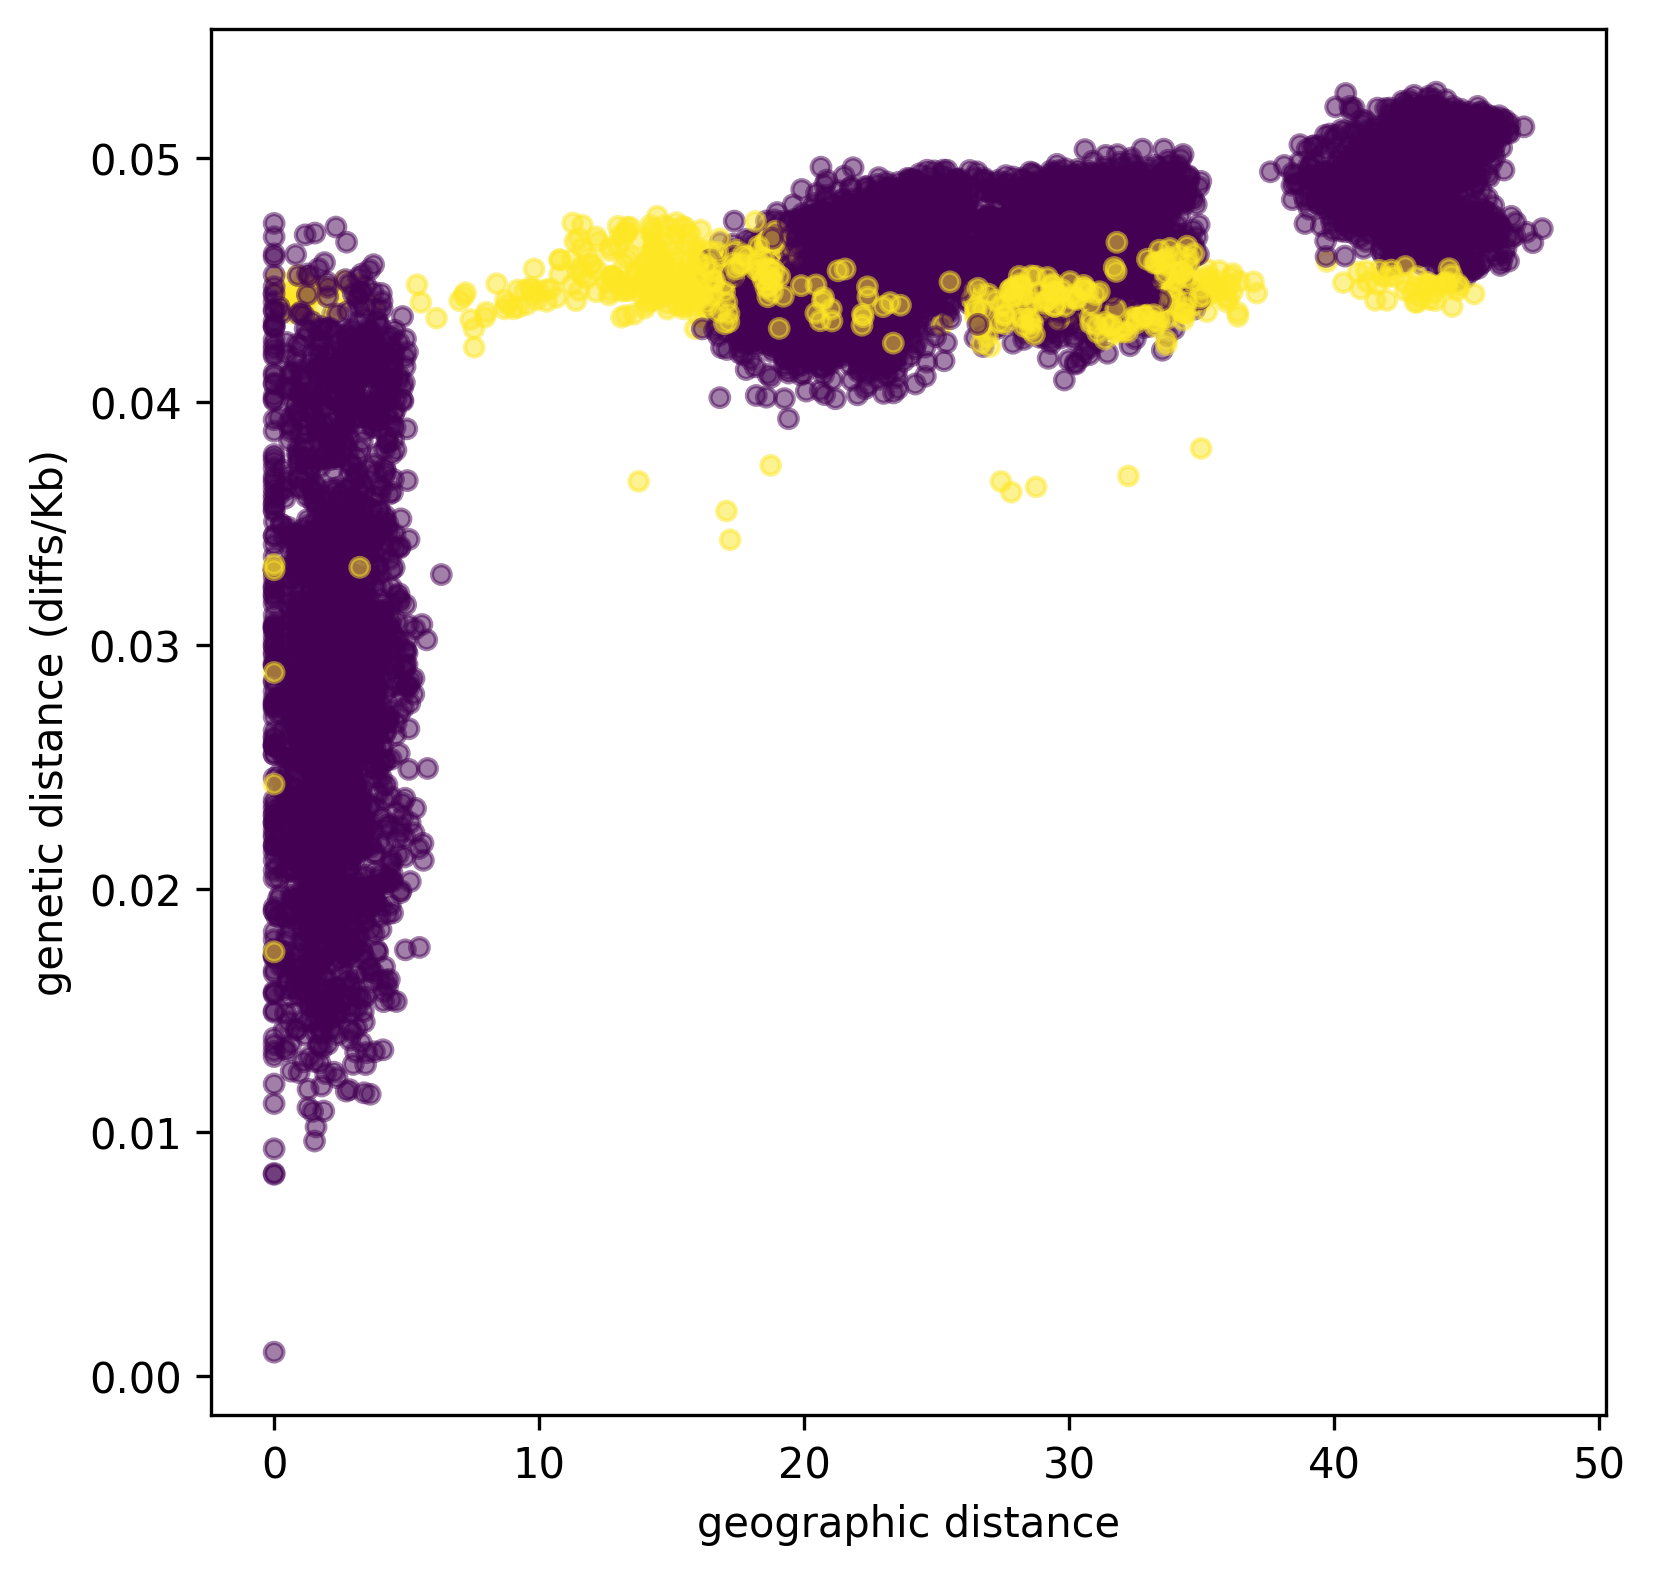

In [20]:
pair_colors = np.repeat(0, len(pairs))
for k, (i, j) in enumerate(pairs):
  if ind_group[i] == "ancient" or ind_group[j] == "ancient":
     pair_colors[k] = 1

fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111)
ax.scatter(geog_dist, 1e3 * ind_div, s=20, alpha=0.5,
          c=pair_colors)
ax.set_xlabel("geographic distance")
ax.set_ylabel("genetic distance (diffs/Kb)");

Since we multiplied ``ind_div`` by 1,000,
the units of genetic distance are in mean number of nucleotide differences per kilobase.
It is clear that closer samples are more closely related,
and the distinct clusters corresponding to the five sampled boxes are visible.
Furthermore, ancient samples are generally more distantly diverged.


## VCF output

Now we want to write out these data for analysis with other programs.
To do this, and make sure that everything stays nicely cross-referenced,
we're going to loop through the sampled individuals, writing their information to a file,
while at the same time constructing a list of individual IDs,
whose genomes we will write out to a VCF file.

In [21]:
indivlist = []
indivnames = []
with open("spatial_sim_individuals.txt", "w") as indfile:
    indfile.writelines("\t".join(["vcf_label", "tskit_id", "slim_id"]
                                 + ["birth_time_ago", "age", "x", "y"]) + "\n")
    for group in group_order:
        for i in groups[group]:
           indivlist.append(i)
           ind = ts.individual(i)
           vcf_label = f"tsk_{ind.id}"
           indivnames.append(vcf_label)
           time = ts.node(ind.nodes[0]).time
           data = [vcf_label, str(ind.id), str(ind.metadata["pedigree_id"]), str(time),
                   str(ind.metadata["age"]), str(ind.location[0]), str(ind.location[1])]
           indfile.writelines("\t".join(data) + "\n")

with open("spatial_sim_genotypes.vcf", "w") as vcffile:
   ts.write_vcf(vcffile, individuals=indivlist, individual_names=indivnames)

## More information

1. The distinction between "nodes" (i.e., genomes) and "individuals" can be confusing,
   as well as the idea of "samples".
   Please see the
   [tskit documentation](tskit:sec_data_model)
   for more explanation about these concepts.

2. The general interface for computing statistics (explaining, for instance, the "indexes"
   argument above) is described in [tskit documentation](tskit:sec_stats) also.


## What about simplification?

The tree sequence we worked with here contains more information than we need,
including the first generation individuals.
If we wanted to remove this, we could have used the
{meth}`simplify <tskit.TreeSequence.simplify>` method,
which reduced the tree sequence to the minimal required to record the information
about a provided set of nodes.
In the workflow above we didn't ever *simplify* the tree sequence,
because we didn't need to.
Because simplify reorders nodes and removes unused individuals and populations,
it requires an extra layer of bookkeeping.
Such relabeling also makes it harder to compare results across different analyses
of the same data.

Simplifying the tree sequence down to the nodes of the individuals
in our "groups" would not change any subsequent analysis (except perhaps
removing monomorphic sites in the VCF output),
and would speed up computation of diversity.
Since the calculation was fast already, it wasn't worth it in this case,
but for much larger tree sequences it could be worth the extra code complexity.